In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple

In [ ]:
# Define Environment
class UrbanPlanningEnv(gym.Env):
    """Custom Environment for Urban Planning using gym"""

    def __init__(self, grid_size=20, hazard_types=3):
        super(UrbanPlanningEnv, self).__init__()

        self.grid_size = grid_size
        self.hazard_types = hazard_types

        # Define action space:
        # for each cell, choose a land use type:
        # 0: Undeveloped,
        # 1: Green Infrastructure,
        # 2: Residential,
        # 3: Commercial,
        # 4: Industrial,
        # 5: Evacuation route,
        # 6: Shelter,
        # 7: Barrier,
        # 8: Storm drain
        self.n_actions = 9
        self.action_space = spaces.MultiDiscrete([self.n_actions] * (grid_size * grid_size))
        # MultiDiscrete represents the cartesian product of arbitrary Discrete spaces.
        # The action_space is a 2D + Channels = 3D

        # Define observation space
        # For each cell, include its:
        # elevation,
        # soil type,
        # distance from water,
        # hazard risks,
        # current land use (one-hot encoding) (categorical)
        observation_shape = (
            grid_size,
            grid_size,
            3 + hazard_types + self.n_actions  # 3 base features + hazards + land use
        )

        self.observation_space = spaces.Box(
            low=0, high=1,
            shape=observation_shape,  # (20, 20, 15)
            dtype=np.float32
        )
        # spaces.Box represents the Cartesian product of n closed intervals

        # Initialize state
        self.reset()

    def import_terrain_data(self):
        """
        Collect: (what is available (could be more or less))
        Elevation
        Water bodies
        Distance from water
        Soil type
        """
        pass

    def generate_terrain(self):
        """Generate random terrain with realistic features"""
        # Simple elevation model (could be replaced with real DEM data)
        x = np.linspace(0, 1, self.grid_size)
        y = np.linspace(0, 1, self.grid_size)
        X, Y = np.meshgrid(x, y)

        # Create hills and valleys
        elevation = 0.3 * np.sin(3 * np.pi * X) * np.cos(3 * np.pi * Y)
        elevation += 0.2 * np.sin(5 * np.pi * X * Y)
        elevation = (elevation - elevation.min()) / (elevation.max() - elevation.min())

        # Create a river/water body
        water_dist = np.abs(Y - 0.5 * np.sin(3 * np.pi * X))
        water_body = water_dist < 0.05

        # Distance to water
        from scipy.ndimage import distance_transform_edt
        water_distance = distance_transform_edt(~water_body)
        water_distance = water_distance / water_distance.max()

        # Soil types (0-1 representing different permeability)
        soil = 0.7 * elevation + 0.3 * np.random.rand(self.grid_size, self.grid_size)

        return elevation, water_body, water_distance, soil

    def import_hazard_data(self):
        """
        Collect: (what is available (could be more or less))
        Flood risk
        Fire risk
        Earthquake risk
        """
        pass

    def generate_hazard_risks(self, elevation, water_distance):
        """Generate hazard risk maps"""
        # Flood risk (higher near water, lower at high elevations)
        flood_risk = (1 - elevation) * (1 - water_distance)
        flood_risk = (flood_risk - flood_risk.min()) / (flood_risk.max() - flood_risk.min() + 1e-6)

        # Fire risk (higher at higher elevations, lower near water)
        fire_risk = elevation * water_distance
        fire_risk = (fire_risk - fire_risk.min()) / (fire_risk.max() - fire_risk.min() + 1e-6)

        # Earthquake risk (random for this prototype)
        earthquake_risk = np.random.rand(self.grid_size, self.grid_size)

        return np.stack([flood_risk, fire_risk, earthquake_risk], axis=-1)

    def import_infrastructure_data(self):
        """
        Collect Land Use: (what is available (could be more or less))
        Green infrastructure
        Evacuation routes
        Shelters
        Barriers
        Storm drains
        """
        pass

    def reset_infrastructure(self):
        """Reset infrastructure to initial state from data"""
        terrain_features = self.import_terrain_data()
        hazard_features = self.import_hazard_data()
        self.land_use = np.zeros((self.grid_size, self.grid_size), dtype=int)


    def reset(self, seed=None):
        """Reset the environment to an initial state"""
        if seed is not None:
            np.random.seed(seed)

        # Generate terrain and hazards
        self.elevation, self.water_body, self.water_distance, self.soil = self.generate_terrain()
        self.hazard_risks = self.generate_hazard_risks(self.elevation, self.water_distance)

        # Initialize blank land use plan
        self.land_use = np.zeros((self.grid_size, self.grid_size), dtype=int)

        # Set water bodies as undevelopable
        self.land_use[self.water_body] = 0

        # Create initial state observation
        self.state = self._get_observation()

        # Reset metrics
        self.step_count = 0

        return self.state, {}

    def _get_observation(self):
        """Construct the observation from current state"""
        # One-hot encode land use
        land_use_onehot = np.zeros((self.grid_size, self.grid_size, self.n_actions))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                land_use_onehot[i, j, self.land_use[i, j]] = 1

        # Combine all features
        obs = np.dstack([
            self.elevation.reshape(self.grid_size, self.grid_size, 1),
            self.soil.reshape(self.grid_size, self.grid_size, 1),
            self.water_distance.reshape(self.grid_size, self.grid_size, 1),
            self.hazard_risks,
            land_use_onehot
        ])

        return obs

    def step(self, action):
        """Execute one planning step"""
        # Convert flattened action back to grid
        action_grid = action.reshape(self.grid_size, self.grid_size)

        # Apply actions (update land use)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # Don't allow building on water
                if not self.water_body[i, j]:
                    self.land_use[i, j] = action_grid[i, j]

        # Update state
        self.state = self._get_observation()
        self.step_count += 1

        # Calculate rewards
        disaster_resilience = self._calculate_disaster_resilience()
        sustainability = self._calculate_sustainability()
        economic_viability = self._calculate_economic_viability()
        social_equity = self._calculate_social_equity()

        # Multi-objective reward
        rewards = {
            'disaster_resilience': disaster_resilience,
            'sustainability': sustainability,
            'economic_viability': economic_viability,
            'social_equity': social_equity,
            'total': disaster_resilience + sustainability + economic_viability + social_equity
        }

        # Check if episode is done
        done = self.step_count >= 1  # Only one planning step for now

        return self.state, rewards, done, False, {}

    def _calculate_disaster_resilience(self):
        """Calculate disaster resilience metrics"""
        flood_protection = self._calculate_flood_protection()
        fire_protection = self._calculate_fire_protection()
        evacuation_efficiency = self._calculate_evacuation_efficiency()

        return 0.4 * flood_protection + 0.3 * fire_protection + 0.3 * evacuation_efficiency

    def _calculate_flood_protection(self):
        """Calculate flood protection score"""
        # Green infrastructure helps with flood absorption
        green_infra_mask = (self.land_use == 1)
        storm_drain_mask = (self.land_use == 8)
        barrier_mask = (self.land_use == 7)

        # Buildings in flood-prone areas are bad
        building_mask = np.isin(self.land_use, [2, 3, 4])
        flood_risk = self.hazard_risks[:, :, 0]

        # Calculate building exposure to flood risk
        building_flood_exposure = np.sum(building_mask * flood_risk) / (np.sum(building_mask) + 1e-6)

        # Green infrastructure and drains in flood-prone areas are good
        green_drain_flood_protection = np.sum((green_infra_mask | storm_drain_mask) * flood_risk) / \
                                       (np.sum(flood_risk) + 1e-6)

        # Barriers protecting high-risk areas
        # (simplified - in reality would need flow modeling)
        barrier_protection = np.sum(barrier_mask * np.roll(flood_risk, 1, axis=0)) / \
                             (np.sum(flood_risk) + 1e-6)

        # Combine metrics (lower exposure is better, higher protection is better)
        return 0.4 * (1 - building_flood_exposure) + 0.4 * green_drain_flood_protection + 0.2 * barrier_protection

    def _calculate_fire_protection(self):
        """Calculate fire protection score"""
        # Fire buffer zones help with fire protection
        buffer_mask = (self.land_use == 6)

        # Buildings in fire-prone areas are bad
        building_mask = np.isin(self.land_use, [2, 3, 4])
        fire_risk = self.hazard_risks[:, :, 1]

        # Calculate building exposure to fire risk
        building_fire_exposure = np.sum(building_mask * fire_risk) / (np.sum(building_mask) + 1e-6)

        # Buffer zones in fire-prone areas are good
        buffer_fire_protection = np.sum(buffer_mask * fire_risk) / (np.sum(fire_risk) + 1e-6)

        # Combine metrics
        return 0.6 * (1 - building_fire_exposure) + 0.4 * buffer_fire_protection

    def _calculate_evacuation_efficiency(self):
        """Calculate evacuation efficiency"""
        # Evacuation routes and shelters
        route_mask = (self.land_use == 5)
        shelter_mask = (self.land_use == 6)
        building_mask = np.isin(self.land_use, [2, 3, 4])

        # Simple metric: ratio of routes and shelters to buildings
        if np.sum(building_mask) == 0:
            return 0

        route_ratio = np.sum(route_mask) / np.sum(building_mask)
        shelter_ratio = np.sum(shelter_mask) / np.sum(building_mask)

        # Ideal ratios (simplified)
        ideal_route_ratio = 0.2
        ideal_shelter_ratio = 0.05

        route_score = 1 - min(1, abs(route_ratio - ideal_route_ratio) / ideal_route_ratio)
        shelter_score = 1 - min(1, abs(shelter_ratio - ideal_shelter_ratio) / ideal_shelter_ratio)

        return 0.6 * route_score + 0.4 * shelter_score

    def _calculate_sustainability(self):
        """Calculate sustainability metrics"""
        # Green space percentage
        green_space_ratio = np.sum(self.land_use == 1) / (self.grid_size ** 2)

        # Water management (green infra and drains near flood zones)
        flood_risk = self.hazard_risks[:, :, 0]
        green_infra_mask = (self.land_use == 1)
        storm_drain_mask = (self.land_use == 8)
        water_mgmt_score = np.sum((green_infra_mask | storm_drain_mask) * flood_risk) / \
                           (np.sum(flood_risk) + 1e-6)

        # Ideal green space ratio (simplified)
        ideal_green_ratio = 0.3
        green_score = 1 - min(1, abs(green_space_ratio - ideal_green_ratio) / ideal_green_ratio)

        return 0.6 * green_score + 0.4 * water_mgmt_score

    def _calculate_economic_viability(self):
        """Calculate economic viability metrics"""
        # Building land use ratio (commercial & residential are valuable)
        commercial_ratio = np.sum(self.land_use == 3) / (self.grid_size ** 2)
        residential_ratio = np.sum(self.land_use == 2) / (self.grid_size ** 2)

        # Infrastructure cost (simplified)
        infrastructure_ratio = np.sum(np.isin(self.land_use, [5, 7, 8])) / (self.grid_size ** 2)

        # Ideal ratios (simplified)
        ideal_commercial = 0.2
        ideal_residential = 0.4
        max_infrastructure = 0.15

        commercial_score = 1 - min(1, abs(commercial_ratio - ideal_commercial) / ideal_commercial)
        residential_score = 1 - min(1, abs(residential_ratio - ideal_residential) / ideal_residential)
        infra_cost_score = 1 - min(1, infrastructure_ratio / max_infrastructure)

        return 0.4 * commercial_score + 0.4 * residential_score + 0.2 * infra_cost_score

    def _calculate_social_equity(self):
        """Calculate social equity metrics"""
        # Access to green spaces from residential areas
        residential_mask = (self.land_use == 2)
        green_mask = (self.land_use == 1)

        # Simple proximity metric (in reality would use network distance)
        from scipy.ndimage import distance_transform_edt
        if np.sum(green_mask) > 0 and np.sum(residential_mask) > 0:
            distance_to_green = distance_transform_edt(~green_mask)
            avg_distance = np.sum(distance_to_green * residential_mask) / np.sum(residential_mask)
            max_possible_distance = np.sqrt(2) * self.grid_size
            green_access = 1 - (avg_distance / max_possible_distance)
        else:
            green_access = 0

        # Shelter accessibility
        shelter_mask = (self.land_use == 6)
        if np.sum(shelter_mask) > 0 and np.sum(residential_mask) > 0:
            distance_to_shelter = distance_transform_edt(~shelter_mask)
            avg_shelter_distance = np.sum(distance_to_shelter * residential_mask) / np.sum(residential_mask)
            shelter_access = 1 - (avg_shelter_distance / max_possible_distance)
        else:
            shelter_access = 0

        return 0.5 * green_access + 0.5 * shelter_access

    def render(self):
        """Render the environment"""
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))

        # Terrain and elevation
        axs[0, 0].imshow(self.elevation, cmap='terrain')
        axs[0, 0].set_title('Elevation')

        # Hazard risks
        axs[0, 1].imshow(self.hazard_risks[:,:,0], cmap='Blues', vmin=0, vmax=1)
        axs[0, 1].set_title('Flood Risk')

        axs[0, 2].imshow(self.hazard_risks[:,:,1], cmap='Reds', vmin=0, vmax=1)
        axs[0, 2].set_title('Fire Risk')

        # Land use plan
        colors = ['white', 'green', 'blue', 'red', 'purple', 'yellow', 'orange', 'black', 'cyan']
        labels = ['Undeveloped', 'Green Infra', 'Residential', 'Commercial',
                 'Industrial', 'Evacuation', 'Shelter', 'Barrier', 'Storm Drain']

        cmap = ListedColormap(colors[:self.n_actions])
        land_use_plot = axs[1, 0].imshow(self.land_use, cmap=cmap, vmin=0, vmax=self.n_actions-1)
        axs[1, 0].set_title('Land Use Plan')

        # Custom legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[i], label=labels[i]) for i in range(self.n_actions)]
        axs[1, 1].legend(handles=legend_elements, loc='center')
        axs[1, 1].axis('off')

        # Add water bodies for reference
        water_plot = np.zeros_like(self.land_use)
        water_plot[self.water_body] = 1
        axs[1, 2].imshow(water_plot, cmap='Blues')
        axs[1, 2].set_title('Water Bodies')

        plt.tight_layout()
        return fig

In [ ]:
# Define the RL Agent
class DQNAgent:
    def __init__(self, env, learning_rate=1e-4, gamma=0.99, epsilon_start=1.0,
                epsilon_end=0.01, epsilon_decay=0.995, buffer_size=10000,
                batch_size=64, target_update=10):

        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        self.buffer_size = buffer_size

        # Get state and action dimensions
        state_shape = env.observation_space.shape
        self.state_size = np.prod(state_shape)
        self.action_size = env.action_space.nvec[0]  # Same action space for each cell
        self.grid_size = env.grid_size

        # Create Q networks
        self.q_network = self._build_q_network(state_shape, self.action_size)
        self.target_network = self._build_q_network(state_shape, self.action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Define optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Initialize replay buffer
        self.memory = ReplayBuffer(buffer_size)

        # Training metrics
        self.train_step = 0

    def _build_q_network(self, input_shape, action_size):
        """Build a Q-network for processing grid-based state

        Args:
            input_shape: Tuple of (height, width, channels)
            action_size: Number of possible actions

        Returns:
            A PyTorch Q-network model
        """
        class QNetwork(nn.Module):
            def __init__(self, input_shape, action_size):
                super(QNetwork, self).__init__()

                # Correctly parse input dimensions
                # Expected input shape: (height, width, channels)
                self.height, self.width, self.channels = input_shape

                # CNN layers
                self.conv1 = nn.Conv2d(self.channels, 32, kernel_size=3, padding=1)
                self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
                self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

                # Fully connected layers
                flat_size = self.height * self.width * 64
                self.fc1 = nn.Linear(flat_size, 512)
                self.fc2 = nn.Linear(512, self.height * self.width * action_size)

            def forward(self, x):
                batch_size = x.size(0)

                # Rearrange input for CNN: (batch, height, width, channels) -> (batch, channels, height, width)
                x = x.permute(0, 3, 1, 2)

                # CNN backbone
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = F.relu(self.conv3(x))

                # Flatten the output
                x = x.reshape(batch_size, -1)

                # Fully connected layers
                x = F.relu(self.fc1(x))
                x = self.fc2(x)

                # Reshape to (batch, height*width, actions)
                x = x.view(batch_size, self.height * self.width, action_size)

                return x

        return QNetwork(input_shape, action_size)

# Example instantiation:
# model = QNetwork(input_shape=(height, width, channels), action_size=num_actions)

    def select_action(self, state, epsilon=None):
        """Select action using epsilon-greedy policy"""
        if epsilon is None:
            epsilon = self.epsilon

        # Random action with probability epsilon
        if random.random() < epsilon:
            # Random action for each cell
            return np.array([random.randint(0, self.action_size-1)
                            for _ in range(self.grid_size**2)])

        # Greedy action with probability 1-epsilon
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)

            # Select best action for each cell
            actions = torch.argmax(q_values, dim=2).squeeze(0).numpy()
            return actions

    def train(self, num_episodes=1000):
        """Train the agent"""
        rewards_history = []

        for episode in range(num_episodes):
            # Reset the environment
            state, _ = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                # Select and perform action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)

                # Store transition in replay buffer
                self.memory.push(state, action, next_state, reward['total'], done)

                # Move to the next state
                state = next_state
                episode_reward += reward['total']

                # Perform optimization step
                if len(self.memory) > self.batch_size:
                    self._optimize_model()

                # Update target network
                if self.train_step % self.target_update == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())

                self.train_step += 1

            # Decay epsilon
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            # Log progress
            rewards_history.append(episode_reward)
            if episode % 10 == 0:
                print(f"Episode {episode}, Reward: {episode_reward:.4f}, Epsilon: {self.epsilon:.4f}")

        return rewards_history

    def _optimize_model(self):
        """Perform a single optimization step"""
        # Sample batch from replay buffer
        batch = self.memory.sample(self.batch_size)

        # Convert batch to tensors
        states = torch.FloatTensor(np.array([s for s, _, _, _, _ in batch]))
        actions = torch.LongTensor(np.array([a for _, a, _, _, _ in batch]))
        next_states = torch.FloatTensor(np.array([s for _, _, s, _, _ in batch]))
        rewards = torch.FloatTensor(np.array([r for _, _, _, r, _ in batch]))
        dones = torch.FloatTensor(np.array([d for _, _, _, _, d in batch]))

        # Reshape actions to match Q-values shape: (batch, grid*grid, 1)
        actions = actions.reshape(self.batch_size, -1, 1)

        # Compute current Q values
        current_q_values = self.q_network(states)
        current_q_values = current_q_values.gather(2, actions).squeeze(2)

        # Compute target Q values
        with torch.no_grad():
            target_q_values = self.target_network(next_states)
            max_target_q_values = target_q_values.max(2)[0]

            # Apply terminal state handling
            expected_q_values = rewards[:, None] + (1 - dones[:, None]) * self.gamma * max_target_q_values

        # Compute loss
        loss = nn.MSELoss()(current_q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [ ]:
# Replay Buffer for DQN
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.Transition = namedtuple('Transition',
                                   ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Utility Functions for Visualization
def visualize_plan(env, plan=None):
    """Visualize the urban plan"""
    if plan is not None:
        # Save current land use
        old_land_use = env.land_use.copy()

        # Update with new plan
        plan_grid = plan.reshape(env.grid_size, env.grid_size)
        env.land_use = plan_grid

        # Render
        fig = env.render()

        # Restore original land use
        env.land_use = old_land_use

        return fig
    else:
        # Render current state
        return env.render()

Training the agent (short demo)...
Episode 0, Reward: 1.8460, Epsilon: 0.9950
Episode 10, Reward: 1.9259, Epsilon: 0.9464
Episode 20, Reward: 1.8614, Epsilon: 0.9001
Episode 30, Reward: 1.9915, Epsilon: 0.8561
Episode 40, Reward: 1.7895, Epsilon: 0.8142
Episode 50, Reward: 2.0750, Epsilon: 0.7744
Episode 60, Reward: 1.9487, Epsilon: 0.7366
Episode 70, Reward: 1.9831, Epsilon: 0.7005
Episode 80, Reward: 1.9097, Epsilon: 0.6663
Episode 90, Reward: 1.9775, Epsilon: 0.6337
Episode 100, Reward: 2.0918, Epsilon: 0.6027
Episode 110, Reward: 1.8237, Epsilon: 0.5733
Episode 120, Reward: 1.9873, Epsilon: 0.5452
Episode 130, Reward: 1.9677, Epsilon: 0.5186
Episode 140, Reward: 1.9154, Epsilon: 0.4932
Episode 150, Reward: 2.1291, Epsilon: 0.4691
Episode 160, Reward: 2.1720, Epsilon: 0.4462
Episode 170, Reward: 2.1672, Epsilon: 0.4244
Episode 180, Reward: 2.1498, Epsilon: 0.4036
Episode 190, Reward: 2.1574, Epsilon: 0.3839
Episode 200, Reward: 2.1534, Epsilon: 0.3651
Episode 210, Reward: 2.1554, Ep

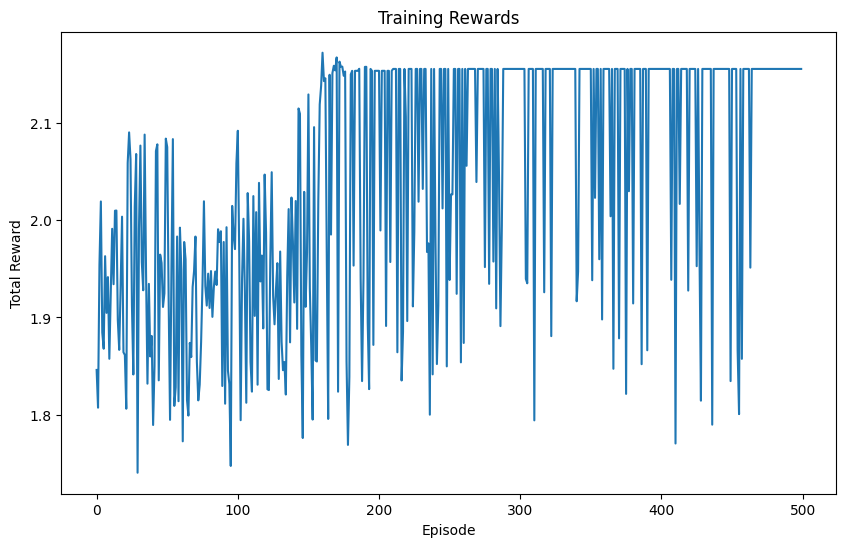


Final Rewards:
disaster_resilience: 0.4695
sustainability: 0.3864
economic_viability: 0.3600
social_equity: 0.9394
total: 2.1554


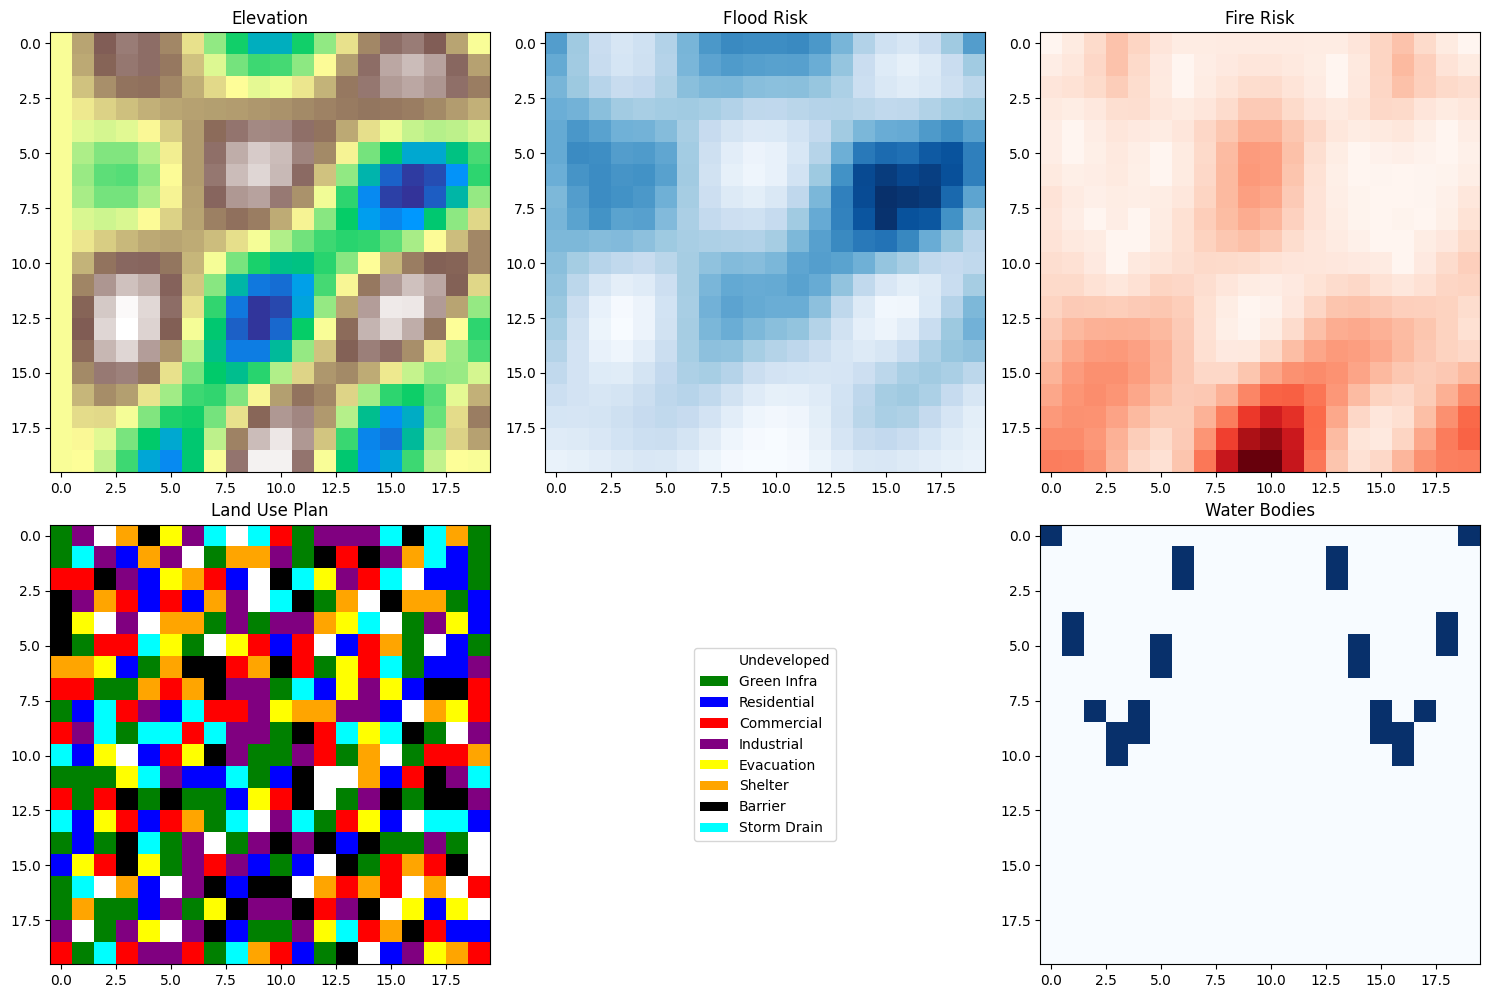

In [ ]:
def run_simple_demonstration():
    """Run a simple demonstration of the system"""
    # Create environment
    env = UrbanPlanningEnv(grid_size=20)

    # Create agent
    agent = DQNAgent(env)

    # Train for a small number of episodes (just for demonstration)
    print("Training the agent (short demo)...")
    rewards = agent.train(num_episodes=500)

    # Plot training rewards
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

    # Test the trained agent
    state, _ = env.reset()
    action = agent.select_action(state, epsilon=0)  # Greedy action
    _, rewards, _, _, _ = env.step(action)

    print("\nFinal Rewards:")
    for key, value in rewards.items():
        print(f"{key}: {value:.4f}")

    # Visualize the plan
    fig = visualize_plan(env, action)
    plt.show()

    return env, agent

if __name__ == "__main__":
    # Run the demonstration
    env, agent = run_simple_demonstration()